# Question 2

This dataset provides monthly operational metrics for a major Indian airline
from 2013. It includes information on the number of departures, flight hours,
distance flown, passenger traffic, available seat kilometers, freight carried,
and mail carried. You can use any popular time series library for this task.

In [995]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

data = pd.read_csv('AirtrafficA4.csv')

Removing `null` values out of the data, adding a new `timestamp` column showing month + year in a specific formate.

In [996]:
data['MONTH'] = data['MONTH'].str.strip()
data['MONTH'] = data['MONTH'].replace({ 'JUNE': 'JUN', 'JULY': 'JUL' })
data['YEAR'] = data['YEAR'].astype(str)
data['MONTH'] = data['MONTH'].astype(str)
data['TIMESTAMP'] = pd.to_datetime(data['YEAR'] + '-' + data['MONTH'] + '-01', format='%Y-%b-%d')
data.fillna(0, inplace=True)
print(data.loc[35])
data.replace(['', ' ', 'NA', 'N/A', 'null', 'NULL'], pd.NA, inplace=True)

AIRLINE                                                  A007
YEAR                                                     2020
MONTH                                                     APR
TOTAL DEPARTURES                                            0
HOURS FLOWN                                                 0
KILOMETRE FLOWN                                             0
PASSENGERS CARRIED                                          0
AVAILABLE SEAT KILOMETRE (IN THOUSAND)                      0
 FREIGHT CARRIED (IN TONNE)                                 0
MAIL CARRIED (IN TONNE)                                     0
TIMESTAMP                                 2020-04-01 00:00:00
Name: 35, dtype: object


Making `TIMESTAMP` as the index and sorting according to it, so I can plot easily

In [997]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.set_index('TIMESTAMP', inplace=True)
data.index = data.index.to_period('M').to_timestamp()
data = data.asfreq('MS')

print(data.loc['2020-04-01'])
data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].astype(str).str.replace(',', '').astype(float)
data.sort_index(inplace=True)
data.to_csv('Temp.csv')

AIRLINE                                   A007
YEAR                                      2020
MONTH                                      APR
TOTAL DEPARTURES                             0
HOURS FLOWN                                  0
KILOMETRE FLOWN                              0
PASSENGERS CARRIED                           0
AVAILABLE SEAT KILOMETRE (IN THOUSAND)       0
 FREIGHT CARRIED (IN TONNE)                  0
MAIL CARRIED (IN TONNE)                      0
Name: 2020-04-01 00:00:00, dtype: object


Plotting a graph of passengers carried by the plan each month

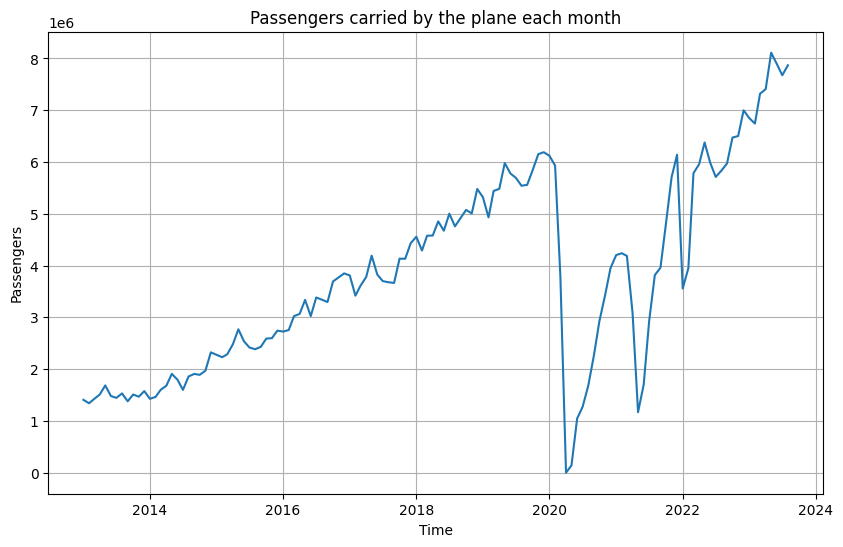

In [998]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['PASSENGERS CARRIED'])
plt.title('Passengers carried by the plane each month')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

Since the data is sorted according to `TIMESTAMP`, let's just split it into training and testing data

In [999]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

Let's scale the data first so that the values are between 0 and 1

In [1000]:
scaler = MinMaxScaler()
train.loc[:,'PASSENGERS CARRIED'] = scaler.fit_transform(train[['PASSENGERS CARRIED']])
test.loc[:,'PASSENGERS CARRIED'] = scaler.transform(test[['PASSENGERS CARRIED']])

train.to_csv('Train.csv')
test.to_csv('Test.csv')

Adding 12 Lag columns to the data, so that we can predict the next value based on the previous 12 values

In [1001]:
lag_length = 12
train_wLag = train.copy()
test_wLag = test.copy()
for i in range(1, lag_length + 1):
    train_wLag.loc[:, f'lag_{i}'] = train_wLag['PASSENGERS CARRIED'].shift(i)
    test_wLag.loc[:, f'lag_{i}'] = test_wLag['PASSENGERS CARRIED'].shift(i)
    
train_wLag.to_csv('Train.csv')
test_wLag.to_csv('Test.csv')

Let's add cyclic features by converting the month to sin and cos features to capture the seasonality

In [1002]:
train_wLag.loc[:, 'month_sin'] = np.sin(2 * np.pi * train_wLag.index.month / 12)
train_wLag.loc[:, 'month_cos'] = np.cos(2 * np.pi * train_wLag.index.month / 12)
test_wLag.loc[:, 'month_sin'] = np.sin(2 * np.pi * test_wLag.index.month / 12)
test_wLag.loc[:, 'month_cos'] = np.cos(2 * np.pi * test_wLag.index.month / 12)

train_wLag.to_csv('Train.csv')
test_wLag.to_csv('Test.csv')


Let's finally implement the ARIMA model

In [1003]:
model = ARIMA(train_wLag['PASSENGERS CARRIED'], order=(4,1,1))
model_fit = model.fit()
predictions = model_fit.forecast(steps=len(test_wLag))
print(predictions)

2021-07-01    0.372998
2021-08-01    0.381129
2021-09-01    0.411601
2021-10-01    0.455081
2021-11-01    0.472956
2021-12-01    0.475160
2022-01-01    0.473920
2022-02-01    0.468434
2022-03-01    0.460134
2022-04-01    0.452879
2022-05-01    0.447959
2022-06-01    0.445128
2022-07-01    0.444164
2022-08-01    0.444625
2022-09-01    0.445824
2022-10-01    0.447195
2022-11-01    0.448398
2022-12-01    0.449253
2023-01-01    0.449716
2023-02-01    0.449845
2023-03-01    0.449748
2023-04-01    0.449534
2023-05-01    0.449294
2023-06-01    0.449087
2023-07-01    0.448945
2023-08-01    0.448871
Freq: MS, Name: predicted_mean, dtype: float64


Finally, let's evaluate the model

In [1004]:
def mase(actual, predicted, seasonality=12):
    n = len(actual)
    d = np.abs(np.diff(actual, n=seasonality)).mean()  # Naive benchmark with seasonality
    errors = np.abs(actual - predicted)
    return errors.mean() / d

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

def evaluate_forecasts(actual, predicted):
    # Removing NaN values for evaluation
    actual, predicted = actual[~np.isnan(predicted)], predicted[~np.isnan(predicted)]

    mae = mean_absolute_error(actual, predicted)
    mape_val = mape(actual, predicted)
    mase_val = mase(actual, predicted)

    print(f'MAE: {mae}')
    print(f'MAPE: {mape_val}%')
    print(f'MASE: {mase_val}')

evaluate_forecasts(test['PASSENGERS CARRIED'].values, predictions)


MAE: 0.52564795851133
MAPE: 51.17373636398553%
MASE: 0.010328441470403718
